In [248]:
import os
import pandas as pd
pd.options.display.max_columns = None
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

region = 'GB'

In [15]:
def searchVideo(query):
    api_key = os.environ.get('YT_API')

    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    youtube = googleapiclient.discovery.build(
        "youtube", "v3", developerKey=api_key)

    request = youtube.search().list(
        part="snippet",
        maxResults=3,
        q=query
    )
    response = request.execute()
    return response

### Uzupełnianie brakujących linków do thumbnaili

In [13]:
import json
import pandas as pd

def fixThumbnailURL(row):
    response = searchVideo(row.title)
    thumbnailURL = response['items'][0]['snippet']['thumbnails']['default']['url']
    searchedVideoID = response['items'][0]['id']['videoId']
    
    if (searchedVideoID == row.video_id):
        row.thumbnail_link = thumbnailURL
    else:
        row.thumbnail_link = "N/A"
    return row

df = pd.read_csv(f"./../../our_data/Etap2/lilatee/{region}-06_sentiment.csv")
df_org = pd.read_csv(f"./../../our_data/Etap1/{region}.csv")
df_org = df_org[["video_id", "title"]]
df = pd.merge(df, df_org, on="video_id")

# CHYBA DZIAŁA, ALE USTAWIONE NA JEDEN WIERSZ PONIŻEJ
df[:1][df.mean_r.isna()].apply(lambda row: fixThumbnailURL(row), axis=1)

<ipython-input-13-27a9fb14b446>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[:1][df.mean_r.isna()].apply(lambda row: fixThumbnailURL(row), axis=1)


,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,...,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,title
0,Jw1Y-zhQURU,N/A,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.0,0.0,John Lewis Christmas Ad 2017 - #MozTheMonster


### Zabawa z pobieraniem filmów nietrending z tych samych kanałów, nieskończone

In [161]:
df = pd.read_csv(f"./../../our_data/Etap1/{region}.csv", dtype={'publish_time': 'str'}, parse_dates=['publish_time'])
df["trending_date"] = df["trending_date"].apply(lambda x: pd.to_datetime(x, format="%y.%d.%m"))
df[:3]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region,pub_date,pub_day_of_the_week,pub_year,pub_month,pub_day,pub_hour,tren_date,tren_day_of_the_week,tren_year,tren_month,tren_day,time_to_trend_in_days,dislikes/likes,likes/views,dislikes/views,comment_count/views,increase_views,increase_likes,increase_dislikes,increase_comms,times_in_trend,avg_views,avg_likes,avg_dislikes,avg_comms,avg_views_increase_per_hour,n_of_tags,title_clean,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_clean,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_list_of_urls,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram
0,Jw1Y-zhQURU,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10 07:38:29+00:00,"[""christmas"", ""john lewis christmas"", ""john le...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB,2017-11-10 07:38:29,4.0,2017.0,11.0,10.0,7.0,2017-11-14 23:59:59,1.0,2017.0,11.0,14.0,4.681597,0.184030,0.007707,0.001418,0.001312,338739.0,2528.0,612.0,-2359.0,14.0,8.229008e+06,61558.357143,11834.857143,7919.785714,1.543173e+06,9,john lewis christmas ad 2017 mozthemonster,45,7,7,0.155556,26,0.577778,2,0.044444,0,click continue story make monsternhttpbitly2mb...,821,98,39,0.047503,608,0.740560,9,0.085262,"[""http://bit.ly/2mboXgj"", ""http://bit.ly/2hg04...",7,0,True,True,True
1,3s1rvMFUweQ,2017-11-14,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12 06:24:44+00:00,"[""SNL"", ""Saturday Night Live"", ""SNL Season 43""...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,GB,2017-11-12 06:24:44,6.0,2017.0,11.0,12.0,6.0,2017-11-14 23:59:59,1.0,2017.0,11.0,14.0,2.732813,0.089746,0.024260,0.002177,0.002617,615290.0,8211.0,783.0,715.0,3.0,1.499560e+06,31691.333333,2861.666667,3271.333333,3.855486e+05,36,taylor swift …ready live snl,41,8,8,0.195122,20,0.487805,5,0.121951,0,musical guest taylor swift performs …ready sat...,417,29,40,0.095923,276,0.661871,18,0.167866,"[""http://www.nbc.com/saturday"", ""http://www.nb...",7,0,True,True,True
2,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10 17:00:03+00:00,"[""Eminem"", ""Walk"", ""On"", ""Water"", ""Aftermath/S...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,GB,2017-11-10 17:00:03,4.0,2017.0,11.0,10.0,17.0,2017-11-14 23:59:59,1.0,2017.0,11.0,14.0,4.291620,0.055142,0.045891,0.002531,0.007336,3380838.0,53222.0,4295.0,-1646.0,14.0,3.017875e+07,950319.000000,56545.571429,130640.500000,3.998159e+06,6,eminem walk water audio ft beyoncé,42,8,6,0.142857,25,0.595238,4,0.095238,0,eminems new track walk water ft beyoncé availa...,594,34,29,0.048822,433,0.728956,9,0.158249,"[""http://shady.sr/WOWEminem"", ""https://goo.gl/...",14,0,True,True,True


In [29]:
print(f'Liczba filmów: {df.shape[0]}')
print(f'Liczba unikalnych kanałów: {df["channel_title"].nunique()}')

Liczba filmów: 3235
Liczba unikalnych kanałów: 1595


<AxesSubplot:title={'center':'d'}, xlabel='channel_title', ylabel='Proportion'>

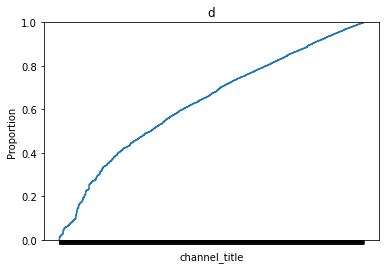

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Turn off x axis labels
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
# plt.title("")
sns.ecdfplot(data=df, x='channel_title')

In [91]:
threshold = 0.35

In [92]:
import numpy as np
n_of_videos = df.shape[0]
channel_nOfOccurences = df["channel_title"].value_counts().reset_index().values
channel_nOfOccurences

array([['The Tonight Show Starring Jimmy Fallon', 51],
       ['TheEllenShow', 47],
       ['Jimmy Kimmel Live', 43],
       ...,
       ["PLAYERUNKNOWN'S BATTLEGROUNDS", 1],
       ['Ghost', 1],
       ['Summoning Salt', 1]], dtype=object)

In [93]:
channel_nOfOccurencesCumSum = channel_nOfOccurences.copy()
channel_nOfOccurencesCumSum[:, 1] = np.cumsum(channel_nOfOccurencesCumSum[:, 1])
channel_nOfOccurencesCumSum

array([['The Tonight Show Starring Jimmy Fallon', 51],
       ['TheEllenShow', 98],
       ['Jimmy Kimmel Live', 141],
       ...,
       ["PLAYERUNKNOWN'S BATTLEGROUNDS", 3233],
       ['Ghost', 3234],
       ['Summoning Salt', 3235]], dtype=object)

In [94]:
selected_id = None
for i, channel in enumerate(channel_nOfOccurencesCumSum):
    if channel[1]/n_of_videos > threshold:
        selected_id = i
        break
        
print(f"Liczba wybranych kanałów: {selected_id+1}")
chosen_channels = channel_nOfOccurences[:, 0][:selected_id+1]

Liczba wybranych kanałów: 97


In [118]:
def searchChannelIdByName(channel_name):
    api_key = os.environ.get('YT_API')

    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    youtube = googleapiclient.discovery.build(
        "youtube", "v3", developerKey=api_key)

    request = youtube.channels().list(
        part="id",
        forUsername=channel_name
    )
    response = request.execute()
    return response['items'][0]['id']

# channelId = searchChannelIdByName("EminemVEVO")

In [191]:
from datetime import datetime, timedelta

def getVideosOfChannelBetweenDates(channel_name, start_datetime, end_datetime):
    api_key = os.environ.get('YT_API')

    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    youtube = googleapiclient.discovery.build(
        "youtube", "v3", developerKey=api_key)

    request = youtube.search().list(
        part="snippet",
        channelId = searchChannelIdByName(channelName),
        type='video',
        publishedBefore=(last_trend_datetime - timedelta(days=30)).isoformat('T') + 'Z',
        publishedAfter=(first_trend_datetime + timedelta(days=30)).isoformat('T') + 'Z',
#         pageToken="CDIQAA",
        maxResults=500

    )
    
    return request.execute()

In [192]:
channelName = 'EminemVEVO'
first_trend_datetime = min(df["trending_date"])
last_trend_datetime = max(df["trending_date"])

response = getVideosOfChannelBetweenDates(channelName, first_trend_datetime, last_trend_datetime )

In [176]:
channel_nOfOccurences[:, 0]

array(['The Tonight Show Starring Jimmy Fallon', 'TheEllenShow',
       'Jimmy Kimmel Live', ..., "PLAYERUNKNOWN'S BATTLEGROUNDS", 'Ghost',
       'Summoning Salt'], dtype=object)

In [ ]:
from pathlib import Path

last_channel_name_filepath = Path("./last_channel.txt")
last_channel_name = ''

if last_channel_name_filepath.is_file():
    with open(last_channel_filepath, 'r') as file:
        last_channel_name = file.read()
else:
    last_channel_name_filepath.mkdir(parents=True, exit_ok=True)

for channelName in channel_nOfOccurences[:, 0]:
    getVideosOfChannelBetweenDates(channelName, first_trend_datetime, last_trend_datetime)

### Pobieranie ground truth dla kategorii

In [230]:
import json
with open("./../../data/youtube_data/_category_id.json") as file:
    data = json.loads(file.read())
    
GB_cats = {}
for item in data['items']:
    GB_cats[item['id']] = item['snippet']['title']
GB_cats

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

In [228]:
with open("./../../data/youtube_data/US_category_id.json") as file:
    data = json.loads(file.read())
    
US_cats = {}
for item in data['items']:
    US_cats[item['id']] = item['snippet']['title']
US_cats

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

In [220]:
print(f"GB - US = {set(GB_cats).difference(set(US_cats))}")
print(f"US - GB = {set(US_cats).difference(set(GB_cats))}")

GB - US = set()
US - GB = {'Nonprofits & Activism'}


In [283]:
def searchVideosByListOfIds(ids_list):
    api_key = os.environ.get('YT_API')

    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    youtube = googleapiclient.discovery.build(
        "youtube", "v3", developerKey=api_key)

    request = youtube.videos().list(
        part="snippet",
        maxResults=50,
        id=ids_list,
    )
    response = request.execute()
    return response

In [247]:
df = pd.read_csv(f"./../../our_data/Etap2/lilatee/{region}-06_sentiment.csv")
df = df[~df.mean_r.isna()]
df["category_id"] = ""
df[:3]

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.502830,71.743704,79.699635,83.992492,83.883918,83.748135,"[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...","[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...","[43570, 1539, 1228, 1489, 1782, 1839, 1918, 20...",6.470819,\r\n,NaN,wigy water an vevo,wigy water vevo,"[""[[25, 118], [173, 194]]"", ""[[282, 116], [468...","[177.0, 202.33333333333334]",177.0,202.333333,0.0
3,PUTEiSjKwJU,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,GB,86.534334,73.284271,69.150666,78.330501,71.675730,68.933206,"[38491, 1841, 1874, 1096, 801, 658, 612, 594, ...","[38491, 1841, 1874, 1096, 801, 658, 612, 594, ...","[38491, 1841, 1874, 1096, 801, 658, 612, 594, ...",6.839139,\r\n\r\ney tderr ott\r\n\r\nSTE a CLASS...,class,3 10 3 92 salford city class of 92 4 dudley2n ...,salford city class dudley2n dieseruvwe webbers...,"[""[[127, 260], [173, 277]]"", ""[[174, 262], [19...","[219.6, 284.9]",219.6,284.900000,0.0
5,AumaWl0TNBo,https://i.ytimg.com/vi/AumaWl0TNBo/default.jpg,GB,95.003171,95.024786,91.284381,71.886971,73.663655,77.643449,"[38545, 2078, 1057, 339, 386, 247, 227, 104, 8...","[38545, 2078, 1057, 339, 386, 247, 227, 104, 8...","[38545, 2078, 1057, 339, 386, 247, 227, 104, 8...",6.807186,\r\n,NaN,NaN,NaN,[],"[-1, -1]",-1.0,-1.000000,0.0


In [362]:
def fillCategoryIds(df, step=50):
    # 50 is max results count returned by YT API
    
    for i in range(0,df.shape[0],step):
        ids_list = df[i:i+step]["video_id"].values.tolist()

        try:
            result = searchVideosByListOfIds(ids_list)
        except:
            df[i:i+step]["category_id"] = ['' for _ in range(step)]
            continue
            
        cats_list = [item['snippet']['categoryId'] for item in result['items']]

        # in case if any id is invalid and returned result list is too short
        if len(cats_list) < step:
            df[i:i+step]["category_id"] = ['' for _ in range(step)]
            continue

        df[i:i+step]["category_id"] = cats_list
        
    return df

In [ ]:
df = fillCategoryIds(df, 50) # First we try to minimize using units in YT API.
df[df["category_id"] == ''] = fillCategoryIds(df[df["category_id"] == ''], 1) # Next we fill missing values.

In [363]:
df[df["category_id"] == '']

,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,hist_r,hist_g,hist_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,category_id
388,PCVtE3wRNPg,https://i.ytimg.com/vi/PCVtE3wRNPg/default.jpg,GB,141.471042,101.775891,96.967980,112.352044,110.953154,111.977977,"[36978, 2643, 1281, 348, 714, 457, 197, 139, 1...","[36978, 2643, 1281, 348, 714, 457, 197, 139, 1...","[36978, 2643, 1281, 348, 714, 457, 197, 139, 1...",4.997187,\r\n,NaN,talk lets,talk let,"[""[[344, 130], [448, 168]]"", ""[[225, 133], [33...","[338.5, 149.75]",338.5,149.75,0.0,
1814,oEtEBOy0ys8,https://i.ytimg.com/vi/oEtEBOy0ys8/default.jpg,GB,99.504589,94.060093,94.125723,87.152131,76.271129,76.082382,"[38292, 2178, 974, 331, 812, 386, 400, 196, 19...","[38292, 2178, 974, 331, 812, 386, 400, 196, 19...","[38292, 2178, 974, 331, 812, 386, 400, 196, 19...",6.700530,\r\n,NaN,seatches,seatches,"[""[[202, 184], [260, 225]]""]","[231.0, 204.5]",231.0,204.50,0.0,


In [366]:
ff = pd.read_csv("./../../our_data/Etap1/GB.csv")
ff[ff["video_id"]=="PCVtE3wRNPg"]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region,pub_date,pub_day_of_the_week,pub_year,pub_month,pub_day,pub_hour,tren_date,tren_day_of_the_week,tren_year,tren_month,tren_day,time_to_trend_in_days,dislikes/likes,likes/views,dislikes/views,comment_count/views,increase_views,increase_likes,increase_dislikes,increase_comms,times_in_trend,avg_views,avg_likes,avg_dislikes,avg_comms,avg_views_increase_per_hour,n_of_tags,title_clean,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_clean,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_list_of_urls,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram
388,PCVtE3wRNPg,17.23.11,"Let's talk... YOUTUBE-MONEY, ZOELLA & PEOPLE C...",Caspar,24.0,2017-11-20T17:08:03.000Z,"[""caspar lee"", ""talk"", ""youtube"", ""zoella"", ""y...",816123,78829,1815,3692,https://i.ytimg.com/vi/PCVtE3wRNPg/default.jpg,False,False,False,I just wanted to talk about a few things on my...,GB,2017-11-20 17:08:03,0.0,2017.0,11.0,20.0,17.0,2017-11-23 23:59:59,3.0,2017.0,11.0,23.0,3.286065,0.023025,0.09659,0.002224,0.004524,59390.0,3023.0,336.0,151.0,12.0,1.034877e+06,88880.833333,3216.916667,4247.583333,248358.765269,11,let talk youtubemoney zoella people changing,53,7,33,0.622642,7,0.132075,7,0.132075,0,wanted talk thing mind moment n follow caspar ...,413,34,27,0.065375,292,0.707022,15,0.1477,"[""http://instagram.com/caspar"", ""http://twitte...",7,0,False,True,True


In [368]:
ff[ff["video_id"]=="PCVtE3wRNPg"]['title'].values

array(["Let's talk... YOUTUBE-MONEY, ZOELLA & PEOPLE CHANGING"],
      dtype=object)